<h1><b>Statistique en Bioinformatique : </b> TME9 </h1><br>

L’objectif de ce TME est l'implementation de la méthode Expectation-Maximisation pour la recherche de motifs.

<div class="alert alert-warning" role="alert" style="margin: 10px">
<div class="alert alert-warning" role="alert" style="margin: 10px">
<p><b>Soumission</b></p>
<ul>
<li>Renomer le fichier TME9.ipynb pour NomEtudiant1_NomEtudiant2.ipynb </li>
<li>Soumettre via moodle </li>
</div>

<H1>Expectation-Maximisation Motif</H1>
<br>
La méthode EM (Expectation-Maximisation) permet de détecter des motifs dans un ensemble de séquences ADN ou protéiques reliées, non alignées. En particulier, étant donné un groupe de séquences de longueur $L$, dont on sait qu'elles partagent un motif commun de longueur $w$, l’algorithme EM:
- infère un modèle $(\Theta,Z)$ pour le motif;
- localise l’occurrence du motif dans chaque séquence.

$\Theta$ representé la matrice des poids-positions $p_{c,k}$ du motif (où $c \in \{A,C,G,T\}$ ou $c \in \{A,C,D,...,W\}$  et $k \in \{0 \dots w\}$), $p_{c,0}$  est le vecteur de probabilités du modèle nul ou "background".
$Ζ$ est la matrice des variables cachées, qui donnent les positions initiales du motif: 
- $Z_{i,j} = 1$, si le motif commence en position $j$ de la séquence $i$,
- $Z_{i,j} = 0$, sinon. 

L’algorithme affine les paramètres du modèle de manière itérative par espérance-maximisation. Chaque itération $t$ se compose de deux étapes:
- (E) Calcul des valeurs attendues $Ζ^{(t)}$ de $Ζ$, étant donnés $\Theta^{(t-1)}$
- (M) Estimation de  $\Theta^{(t)}$  à partir de  $Ζ^{(t)}$

1\. Implémentez une fonction `read_training_file` pour lire le fichier d'entré qui contient un ensemble de séquences ADN non alignées. Pour simplifier nous allons utiliser les données vu en cours du fichier `toyEx.txt`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

nts = ['A', 'C', 'G', 'T']

w = 3
input_f = "toyEx.txt"

def read_training_file(input_f):
    """
    Read a file with no-aligned sequences
    input input_f : file name
    output seqs : list of sequences
    """

    with open(input_f) as file:
        return [line for line in file.read().splitlines() if line]

seqs = read_training_file(input_f)
print (seqs) #['GTCAGG', 'GAGAGT', 'ACGGAG', 'CCAGTC']


['GTCAGG', 'GAGAGT', 'ACGGAG', 'CCAGTC', 'CCAGTC', 'CCAGTC']


2\. Implémentez une fonction `initialiseP` pour initialiser la matrice poids-position $p_{c,k}$. On considère le modèle nul par défaut $p_0 = (0.25, 0.25, 0.25, 0.25)$. Pour initialiser $p^{(t)}$, on prend généralement un motif au hasard dans une sequence, et on fixe à $0.5$ les poids du nucleotide correspondant et à $\frac{1-0.5}{3}$ les trois autres. 

In [2]:
import random

# P : (amino acid, position)      normalized axis=0
# Z : (sequence, offset)          normalized axis=1


def initialiseP(seqs, w, alph):
    """
    Initialise pc,k
    input seqs : list of sequences
    input w : motif length
    input alph : alphabet (nucleotides or amino acids)
    output P: position probability matrix
    """

    seqs_ = np.array([[alph.index(nt) for nt in seq] for seq in seqs])
    motifs = [random.choice(seqs_)[random.randint(0, len(seqs[0]) - w) + i] for i in range(w)]
    prob = np.zeros((len(alph), w)) + 0.5 / (len(alph) - 1)
    prob[motifs, np.arange(w)] = 0.5

    return np.c_[np.zeros(len(alph)) + 0.25, prob]

# Test
p = initialiseP(seqs, w, nts)
print(p)


[[0.25       0.16666667 0.16666667 0.5       ]
 [0.25       0.5        0.16666667 0.16666667]
 [0.25       0.16666667 0.5        0.16666667]
 [0.25       0.16666667 0.16666667 0.16666667]]


3\. Implémenter une fonction `initialiseZ` pour initialiser la matrice $Z$ à uns. Rappelez-vous que la dimension de $Z$ est $nbSeq \times (lenSeq -w +1)$, où $nbSeq$ est le nombre de sequences et $lenSeq$ est la taille/longueur des sequences.

In [3]:
def initialiseZ(seqs, w):
    """
    Initialise Z
    input seqs : list of sequences
    input w : motif length
    output Z :  matrix of motif start positions
    """
    s = len(seqs[0]) - w + 1
    return np.ones((len(seqs), s)) / s

Z = initialiseZ(seqs, w)
print(Z)


[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]


4\. Écrivez une fonction `E_step` pour le pas Expectation qui estime $Z$ à partir de  $p_{c,k}$. 
Écrivez aussi une fonction `normaliseZ` pour normaliser $Z$.

In [4]:
def E_step(seqs, P, Z, w, alph):
    """
    Implement Expectation step
    input seqs : list of sequences
    input P : position probability matrix
    input Z :  matrix of motif start positions
    input w : motif length
    input alph : alphabet (nucleotides or amino acids)
    output Z :  matrix of motif start positions
    """

    seqs_ = np.array([[alph.index(nt) for nt in seq] for seq in seqs])

    for offset in range(Z.shape[1]):
        Z[:, offset] = \
            np.prod(P[:, 0][seqs_[:, :offset]], axis=1) *\
            np.prod(P[seqs_[:, offset:(offset + w)], np.arange(w) + 1], axis=1) *\
            np.prod(P[:, 0][seqs_[:, (offset + w):]], axis=1)

    return Z

def normaliseZ(z):
    """
    Normalise Z matrix
    input Z : unnormalised matrix
    output Zn : normalised matrix
    """

    return z / z.sum(axis=1, keepdims=True)

Z = E_step(seqs, p, Z, w, nts)
z_norm = normaliseZ(Z)
print(z_norm)


[[0.1        0.3        0.3        0.3       ]
 [0.07142857 0.64285714 0.07142857 0.21428571]
 [0.05       0.45       0.45       0.05      ]
 [0.5625     0.1875     0.1875     0.0625    ]
 [0.5625     0.1875     0.1875     0.0625    ]
 [0.5625     0.1875     0.1875     0.0625    ]]


5\. Implémentez une fonction `M_step` pour le pas Maximisation qui estime $p_{c,k}$ à partir de $Z$. 
Utilisez les "pseudocounts" pour éviter les probabilités ègales à zero.

In [5]:
def totalNumberofCH(seqs,alph):

    q = len(alph)
    totalN = np.zeros((q))
    for i in range(q):
        e = alph[i]
        for seq in seqs:
            for s in seq:
                if(s == e):
                    totalN[i]+=1
    return totalN

def M_step(seqs, Z, w, alph):
    """
    Implement Expectation step
    input seqs : list of sequences
    input Z :  matrix of motif start positions
    input w : motif length
    input alph : alphabet (nucleotides or amino acids)
    output P : position probability matrix
    """

    seqs_ = np.array([[alph.index(nt) for nt in seq] for seq in seqs])
    nr = np.zeros((len(alph), w))

    for ch in range(len(alph)):
        for pos in range(w):
            seq_indices, offset_indices = (seqs_[:, pos:(-(w - pos - 1) or None)] == ch).nonzero()
            nr[ch, pos] = Z[seq_indices, offset_indices].sum()

    n = np.c_[np.bincount(seqs_.ravel(), minlength=len(alph)) - nr.sum(axis=1), nr]
    P = (n + 1) / (n.sum(axis=0) + len(alph))

    assert np.allclose(P.sum(axis=0), 1)

    return P

P = M_step(seqs, z_norm, w, nts)
print(P)
print(P.sum(axis=0))


[[0.14066558 0.27696429 0.20553571 0.40803571]
 [0.30340909 0.4        0.30375    0.12875   ]
 [0.34521104 0.19303571 0.36196429 0.28553571]
 [0.21071429 0.13       0.12875    0.17767857]]
[1. 1. 1. 1.]


6\. Écrivez une fonction `likelihood` qui calcule la log-vraisemblance de l'ensemble des sequences.

In [6]:
def likelihood(seqs, Z, P, w, alph):
    """
    Implement log likelihood function of P
    input seqs : list of sequences
    input Z :  matrix of motif start positions
    input p : position probability matrix
    input w : motif length
    input alph : alphabet (nucleotides or amino acids)
    output lLikelihood : log likelihood of P
    """

    M = len(seqs)
    L = len(seqs[0])

    Z_unnormalized = E_step(seqs, P, Z, w, alph)

    # print(np.log((L-w+1)**-M), np.log(Z.sum(axis=1)).sum())
    # print('*', Z.sum(axis=1), np.log(Z.sum(axis=1)))
    return np.log((L-w+1)**-M) + np.log(Z_unnormalized.sum(axis=1)).sum()

    # print(E_step(seqs, P, Z, w, alph))
    # seqs_ = np.array([[alph.index(nt) for nt in seq] for seq in seqs])

    # for offset in range(Z.shape[1]):
    #     Z[:, offset] = np.prod(P[:, 0][seqs_[:, :offset]], axis=1) * np.prod(P[seqs_[:, offset:(offset + w)], np.arange(w) + 1], axis=1) * np.prod(P[:, 0][seqs_[:, (offset + w):]], axis=1)

logvraisemblance = likelihood(seqs, Z, P, w, nts)
print(logvraisemblance)


-46.20969214600032


7\. Implémentez l'algorithme Expectation-Maximisation. Vous calculerez la valeur de la log-vraisemblance totale du modèle à chaque iteration et l'algorithme prendra fin lorsque $\Delta \log \text{Pr}(D | \Theta) < \varepsilon$. Utilisez $\varepsilon = 1e-4$. Votre implementation devra renvoyer les paramètres du modele ($p$ et la log-likelihood associé), ainsi bien que la liste des meilleures positions du motif dans chaque sequence (matrice $Z$). Faites attention à utiliser $Z$ non-normalisé afin de trouver la log-vraisemblance!

Les paramètres du modele:
p:
 [[0.14198319 0.11334391 0.66573237 0.10856069]
 [0.35896132 0.49897079 0.10863272 0.10268158]
 [0.22904691 0.28727597 0.12295333 0.6858675 ]
 [0.27000857 0.10040934 0.10268158 0.10289022]]


log-vraisemblance associé: -40.759233475263635


Z:
 [[2.25616164e-05 1.42292061e-05 3.22731572e-03 2.12191680e-04]
 [1.15180279e-03 2.14307574e-05 1.15180279e-03 1.06806674e-05]
 [6.29049570e-05 1.94291568e-04 4.47632108e-05 1.53125750e-03]
 [1.30634542e-04 7.92661733e-03 6.63216844e-05 5.54136363e-05]
 [1.30634542e-04 7.92661733e-03 6.63216844e-05 5.54136363e-05]
 [1.30634542e-04 7.92661733e-03 6.63216844e-05 5.54136363e-05]]

Les motifs:
seq1: 3  CAG
seq2: 1  GAG
seq3: 4  GAG
seq4: 2  CAG
seq5: 2  CAG
seq6: 2  CAG


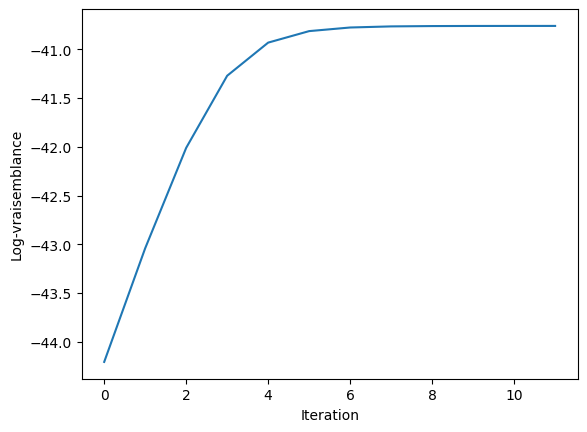

In [7]:
def ExpectationMaximisation(seqs, w, alph, eps):
    """
    Implement Expectation Maximisation algorithm
    input seqs : list of sequences
    input w : motif length
    input alph : alphabet (nucleotides or amino acids)
    input eps : threahold
    output P : position probability matrix
    output Z :  matrix of motif start positions
    output lLikelihood : log likelihood of P
    output pos_motif : positions of motifs in seqs
    """
    P = initialiseP(seqs, w, alph)
    Z = initialiseZ(seqs, w)
    lLikelihood = list[float]()

    for _ in range(100):
        Z = E_step(seqs, P, Z, w, alph)
        Z = normaliseZ(Z)
        P = M_step(seqs, Z, w, alph)
        ll = likelihood(seqs, Z, P, w, alph)

        lLikelihood.append(ll)

        if len(lLikelihood) > 1 and abs(lLikelihood[-1] - lLikelihood[-2]) < eps:
            break

    return P, lLikelihood, Z, Z.argmax(axis=1)

def analyse_results(results, seqs):
    print('Les paramètres du modele:')
    print('p:\n',results[0])
    print('\n')
    print('log-vraisemblance associé:',results[1][-1])
    print('\n')
    print('Z:\n',results[2])
    print('\nLes motifs:')
    for i in range(len(seqs)):
        print('seq'+str(i+1)+': '+ str(results[3][i]+1) + '  ' + seqs[i][results[3][i]:results[3][i]+w])

    plt.plot(results[1])
    plt.xlabel('Iteration')
    plt.ylabel('Log-vraisemblance')
    plt.show()

eps = 10**-4
EMResults = ExpectationMaximisation(seqs, w, nts, eps)
analyse_results(EMResults,seqs)


8\. Qu'est-ce que vous observez en exécutant l'algorithme EM plusieurs fois? Justifiez votre réponse.

Reponse:

<font color="blue">
Les résultats sont très variables d'une exécution à l'autre.
</font>

9\. Pour éviter le problème identifié au point précedent, écrivez une fonction `EM_iteratif` qui exécute l'algorithme `EM` $N$ fois ($N=10$) et qui prend les paramètres associés à la meilleure log-vraisemblance. Trouvez-vous les bons motifs?

Les paramètres du modele:
p:
 [[0.13309686 0.61487127 0.11699057 0.17532507]
 [0.52584649 0.11540408 0.126053   0.10168065]
 [0.2405625  0.1673648  0.65527578 0.24812192]
 [0.10049416 0.10235985 0.10168065 0.47487236]]


log-vraisemblance associé: -39.283794157788186


Z:
 [[1.33279809e-05 3.14927513e-05 1.94820134e-05 1.27087017e-03]
 [1.56320762e-05 4.10817578e-04 1.56320762e-05 1.47369922e-03]
 [1.48124253e-04 7.99602134e-05 3.23732993e-04 8.17965181e-05]
 [3.24224706e-05 9.30884815e-05 2.78203214e-02 6.36834331e-05]
 [3.24224706e-05 9.30884815e-05 2.78203214e-02 6.36834331e-05]
 [3.24224706e-05 9.30884815e-05 2.78203214e-02 6.36834331e-05]]

Les motifs:
seq1: 4  AGG
seq2: 4  AGT
seq3: 3  GGA
seq4: 3  AGT
seq5: 3  AGT
seq6: 3  AGT


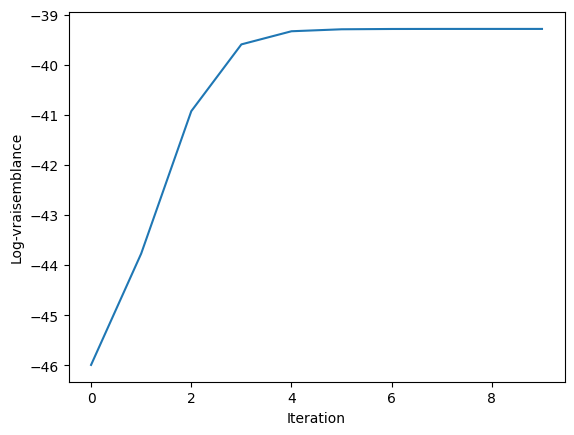

In [8]:
def EM_iteratif(N, seqs, w, alph, eps):
    """
    Implement a iterative version of Expectation Maximisation algorithm
    input N : number of iterations
    input seqs : list of sequences
    input w : motif length
    input eps : threahold
    output bestModel : the parameter of the best model
    """

    best_model = None
    best_likelihood = -np.inf

    for _ in range(N):
        P, likelihoods, Z, offsets = ExpectationMaximisation(seqs, w, alph, eps)

        if likelihoods[-1] > best_likelihood:
            best_model = P, likelihoods, Z, offsets
            best_likelihood = likelihoods[-1]

    assert best_model is not None
    return best_model


eps = 10**-4
N=10
meilleurEM = EM_iteratif(N, seqs, w, nts, eps)
analyse_results(meilleurEM,seqs)


10\. Appliquez votre algorithme `EM` à l'ensemble des séquence du fichier `trainingSequences.txt` en utilisant $w=10$. 

['ACAACCATATATAGTAGCCACTGAAT', 'CCACCCCATATATAGTACGGGTGGTG', 'CCATAAATAGAGCAGACTGTCGCTGT', 'GTAAACATAAAACCCCATAAATAGGA', 'TTCAAGAAACTGCCATAAATAGCGAT', 'TAGAGGTTTTTGTGCCATAAATAGGT', 'CCCCATAAATAGGAATATCGGCCTGA', 'TTGCCATTAAATTATACCATATATGG', 'TATCAACAACGATAACCCATATATGG', 'TTTCCAAATATAGAAGGTGTGGAAAG', 'TCCAAATATAGTAAAATCGAGTCGAT', 'GACTGGGGCCCAAATATAGCATGTTC', 'ATCATTAGCTTTTACTCCATAAATGG', 'ATTCTTTTGCCATAAATGGTAACTCG', 'CCATAAATGGCAAGTCTGTCGAATAA', 'CCCATAAATGGCAGGGTATTAGCACG', 'CCAAAAATAGTGTGTCGTAACAGCTT', 'CCAAAAATAGGGGAATGGAAGTGGGG', 'CCAAAAATAGGCCAGAGTTTACAACG', 'CCAAAAATAGTTAAATAATATACATT', 'CTACACCTTCCAAAAATAGTATATCT', 'TTGCCAAATATGGGGTTAGAGTGTTC', 'GTCTTTACCAAAAATGGTGATCCTGT', 'TTGCCAAAAATGGAGCGTTTACCAAT', 'ATCCACCATTTATAGATTCAGGAGGC', 'GCATAAGAGAACATTCCATTTATAGG', 'TCAACCCCATTTATAGCCACGTCAGT', 'CATCCATTAATAGTAGCCTAATGGCG', 'GGAGTAGGCCCATTAATAGTATCTTT', 'CCATTAATAGACAAAATCGACTCAAG', 'CCAATTATAGAAAGTGGCTGGTCGTC', 'AACTATTATTTCTCACCCATTAATGG', 'ATGCTTTACCAATAATAGAGCTGCAA', 'GGTCAGTT

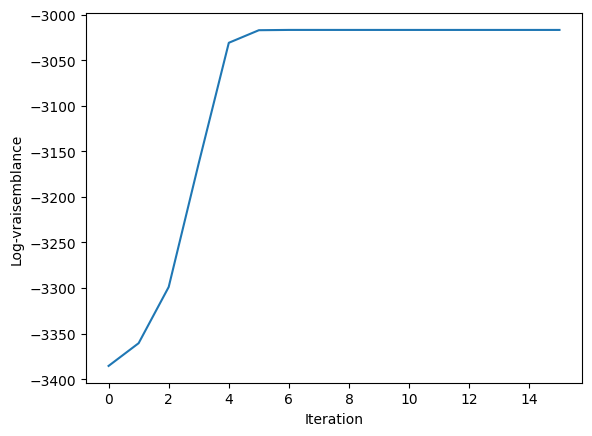

In [9]:
w= 10
input_f = "trainingSequences.txt"
seqs_train = read_training_file(input_f)
print (seqs_train)
eps = 10**-4
N=10
meilleurEM = EM_iteratif(N, seqs_train, w, nts, eps)
analyse_results(meilleurEM,seqs_train)


11\. Construire un LOGO pour le motif prédit avec le service <i>WebLogo</i>. Pour cela, identifiez le motif dans chaque séquence, utiliser <i>ClustalOmega</i> pour les aligner et puis <i>WebLogo</i> pour générer le LOGO. Ajouter le LOGO à votre réponse.

In [10]:
fhandler = open('motifs.txt','w')
for pos in range(len(seqs_train)):
    fhandler.write('>motif'+str(pos+1)+'\n')
    fhandler.write(seqs_train[pos][meilleurEM[3][pos]:meilleurEM[3][pos]+w])
    fhandler.write('\n')
fhandler.close()


![Logo](logo.png)

12\. Comparez les motifs trouvés par votre programme avec les motifs du fichier `testingSequences.txt`, où les vrais motifs sont montrés en lettre majuscule. Quelle est la performance de votre programme? 

In [11]:
import re


input_f = "testingSequences.txt"

def find_offset(line: str):
  match = re.search(r'[A-Z]', line)
  assert match
  return match.span()[0]

with open(input_f) as file:
  real_offsets = np.array([find_offset(line) for line in file.read().splitlines() if line])

correct_offset_count = (real_offsets == meilleurEM[3]).sum()

print(f'L\'algorithme trouve le bon motif dans {correct_offset_count} sequences sur {len(real_offsets)}.')


L'algorithme trouve le bon motif dans 96 sequences sur 97.
